# 🔬 SKINDX: Model Inference & Evaluation

**Deploying Trained Models for Medical Image Classification**

---

🎯 **Notebook Overview**

In the previous step, we **trained and saved the best-performing ResNet model**.  
Here, we will **load that saved model** and run inference on unseen skin lesion images.  
To test generalization, we will evaluate the model on the **ISIC2019 dataset**, which differs from the HAM10000 training data.

---

✅ **Requirements**

- **GPU**: NVIDIA GPU with CUDA support
- **HF Token**: Add your Hugging Face token to a local `.env` file as `HF_TOKEN=<your_token>`  

---

📋 **What We'll Accomplish**

- Load the best **ResNet-based CNN** from the Hugging Face Hub  
- Run inference on **ISIC2019** and generate predictions  
- Evaluate performance with metrics (accuracy, precision, recall, F1)  
- Visualize predictions with confusion matrix and per-class results  

---

🛠️ **Technical Stack**

- **Hardware**: GPU acceleration (tuned for RTX 5080, adaptable to other GPUs)  
- **Evaluation**: Confusion matrix, per-class metrics, and visual predictions  

## 📚 Import Libraries

In [ ]:
# ============================================================
# Standard Library
# ============================================================
import os
import sys
import importlib

# ============================================================
# Third-Party Libraries
# ============================================================
import torch
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

# ============================================================
# Local Project Imports
# ============================================================
sys.path.append("..")

import helpers.tester
importlib.reload(helpers.tester)   # ensure latest changes are loaded
from helpers.tester import Tester


## Load the trained model from MLflow

In [2]:
from huggingface_hub import hf_hub_download

# Download model from Hugging Face
model_path = hf_hub_download(
    repo_id="lisekarimi/resnet50-ham10000",
    filename="resnet50_v010.pth"
)

# Load the downloaded model
trained_model = torch.load(model_path, weights_only=False)
print("Model loaded:", trained_model is not None)
print("Model type:", type(trained_model))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trained_model = trained_model.to(device)
trained_model.eval()

# Quick test with dummy input
dummy_input = torch.randn(1, 3, 224, 224).to(device)
with torch.no_grad():
    output = trained_model(dummy_input)
    print("Output shape:", output.shape)
    print("Predictions:", torch.softmax(output, dim=1))

Model loaded: True
Model type: <class 'torchvision.models.resnet.ResNet'>
Output shape: torch.Size([1, 7])
Predictions: tensor([[1.0784e-11, 2.2067e-15, 9.9994e-01, 4.6083e-09, 4.1078e-05, 1.9102e-05,
         8.4843e-19]], device='cuda:0')


 ## Load ISIC 2019 Dataset
load the ISIC 2019 data from https://www.kaggle.com/datasets/agsam23/isic-2019-challenge/data

In [3]:
input_path_isic2019 = "../data/ISIC_2019"

# Load ground truth CSV
gt_csv = os.path.join(input_path_isic2019, "ISIC_2019_Training_GroundTruth.csv")
isic_df = pd.read_csv(gt_csv)
print(f"Original dataset size: {len(isic_df)}")

# Keep only 7 classes (drop SCC, UNK) since the model was trained on these classes only.
your_classes = ['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC']
filtered_df = isic_df[isic_df[your_classes].sum(axis=1) == 1].copy()
print(f"After filtering: {len(filtered_df)}")

Original dataset size: 25331
After filtering: 24703


In [4]:
# Map ISIC labels to your model labels
label_mapping = {'MEL': 'mel', 'NV': 'nv', 'BCC': 'bcc', 'AK': 'akiec',
               'BKL': 'bkl', 'DF': 'df', 'VASC': 'vasc'}

# Convert one-hot to single label
def get_label(row):
   for col in your_classes:
       if row[col] == 1:
           return label_mapping[col]

filtered_df['diagnosis'] = filtered_df.apply(get_label, axis=1)

# Correct paths with nested folders
train_images_path = os.path.join(input_path_isic2019, "ISIC_2019_Training_Input", "ISIC_2019_Training_Input")
test_images_path = os.path.join(input_path_isic2019, "ISIC_2019_Test_Input", "ISIC_2019_Test_Input")

# Create image path mapping with .jpg extension
image_path_mapping = {}

# Add training images
for img_file in os.listdir(train_images_path):
    if img_file.endswith('.jpg'):
        img_id = os.path.splitext(img_file)[0]
        image_path_mapping[img_id] = os.path.join(train_images_path, img_file)

# Add test images
for img_file in os.listdir(test_images_path):
    if img_file.endswith('.jpg'):
        img_id = os.path.splitext(img_file)[0]
        image_path_mapping[img_id] = os.path.join(test_images_path, img_file)

# Add image paths to dataframe
filtered_df['image_path'] = filtered_df['image'].map(image_path_mapping)

# Remove rows where image path not found
filtered_df = filtered_df.dropna(subset=['image_path'])

print(f"Final dataset size: {len(filtered_df)}")
print("Class distribution:")
print(filtered_df['diagnosis'].value_counts())

Final dataset size: 24703
Class distribution:
diagnosis
nv       12875
mel       4522
bcc       3323
bkl       2624
akiec      867
vasc       253
df         239
Name: count, dtype: int64


In [5]:
# Create inference dataset
class ISICInferenceDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.image_paths = dataframe['image_path'].values
        self.labels = dataframe['diagnosis'].values
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]

        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

# Same preprocessing as our training
inference_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Create dataset and loader
isic_dataset = ISICInferenceDataset(filtered_df, transform=inference_transform)
isic_loader = DataLoader(isic_dataset, batch_size=64, shuffle=False, num_workers=4)

print(f"Ready to test on {len(isic_dataset)} ISIC 2019 images!")

Ready to test on 24703 ISIC 2019 images!


🚀 Starting ISIC 2019 External Validation evaluation...
   Processed 64 samples...
   Processed 3,264 samples...
   Processed 6,464 samples...
   Processed 9,664 samples...
   Processed 12,864 samples...
   Processed 16,064 samples...
   Processed 19,264 samples...
   Processed 22,464 samples...
✅ Completed evaluation on 24,703 samples

ISIC 2019 External Validation - Results Summary
🎯 Overall Accuracy: 0.7123 (71.23%)
📊 Average Confidence: 0.960
📈 Total Samples: 24,703

Performance Breakdown:
  ✅ High Confidence Correct: 16,912 (68.5%)
  ⚠️  Low Confidence Correct:  685 (2.8%)
  ❌ Incorrect Predictions:   7,106 (28.8%)


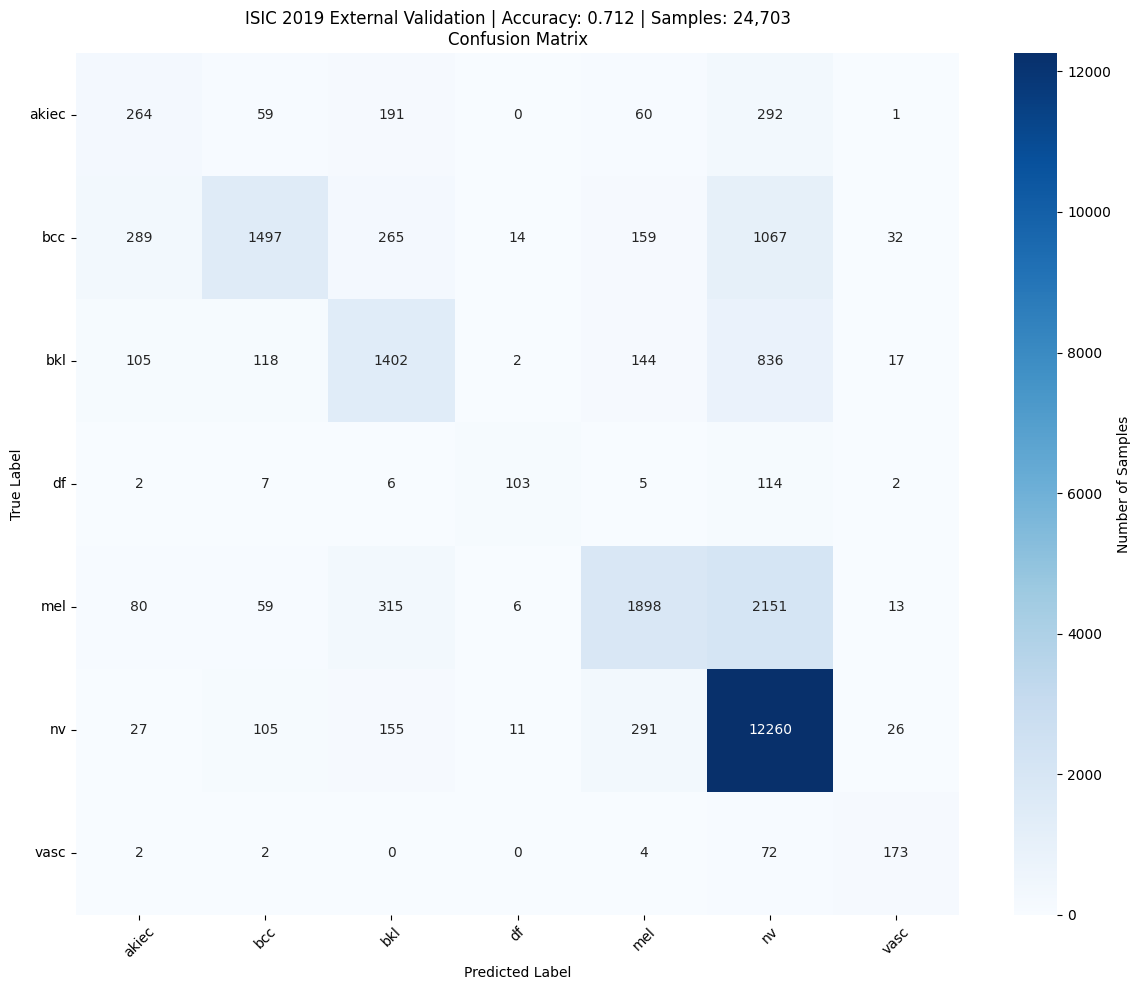

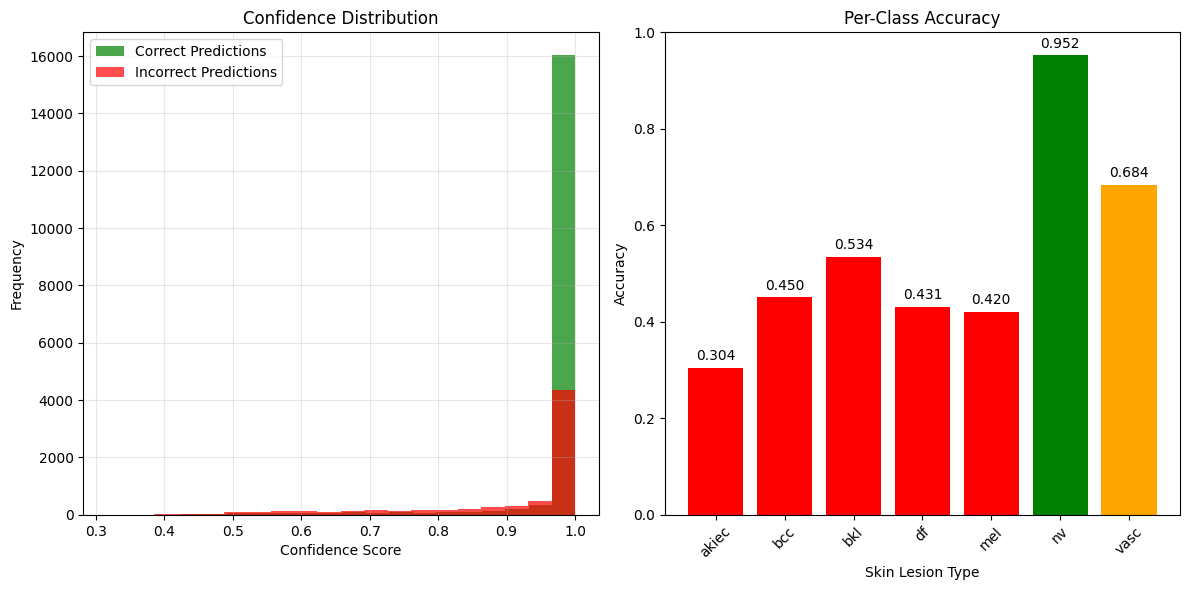

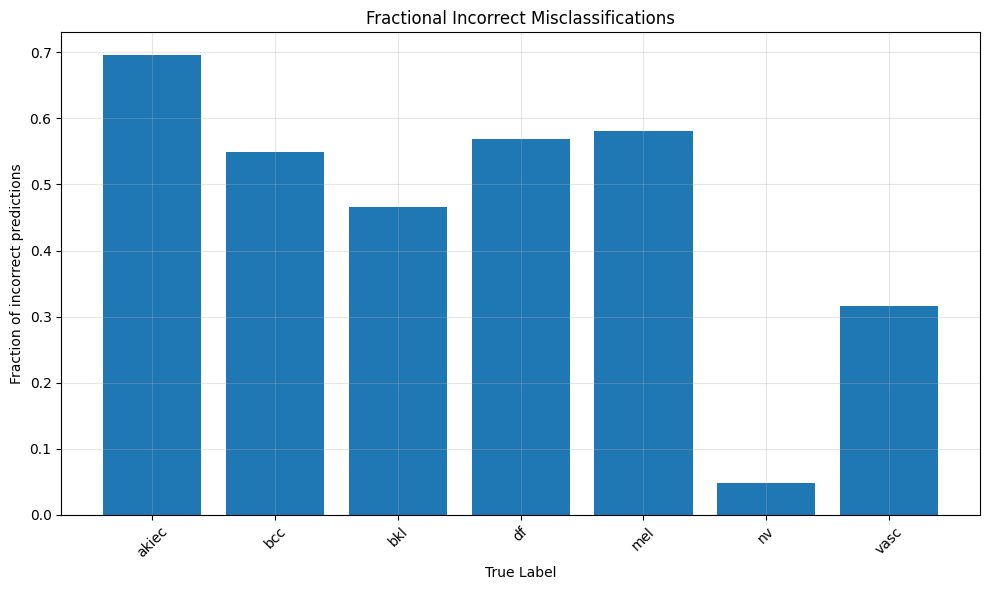


Detailed Classification Report:
              precision    recall  f1-score   support

       akiec       0.34      0.30      0.32       867
         bcc       0.81      0.45      0.58      3323
         bkl       0.60      0.53      0.57      2624
          df       0.76      0.43      0.55       239
         mel       0.74      0.42      0.54      4522
          nv       0.73      0.95      0.83     12875
        vasc       0.66      0.68      0.67       253

    accuracy                           0.71     24703
   macro avg       0.66      0.54      0.58     24703
weighted avg       0.72      0.71      0.69     24703



In [6]:
# Move model to device
trained_model = trained_model.to(device)
trained_model.eval()


# Define label names first
label_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

# Run complete evaluation with Tester
Tester.test(
    model=trained_model,
    dataloader=isic_loader,
    label_names=label_names,
    device=device,
    title="ISIC 2019 External Validation"
)

**Summary:**
Our model scored **88% on HAM10000** and **72% on ISIC 2019** (external dataset).

🔑 **Why it’s good:**

* External validation usually causes a **20–30% drop**; we only saw **16%**.
* **Strong generalization** across different hospitals/equipment.
* Excellent recall on the most common class (**nv: 94%**).
* **Clinically relevant performance** — comparable to published medical AI results.
